# "A/B testing" made simple for everyone.

and: Z-test, chi-square, Beta distribution clean codes for programmers.

##### Clement Riedel, July 2016


You have two doors: one blue, one green. You want to know which one people are going to open. 

<img src="TwoDoors.png">

This is a metaphor. A/B testing is about predicting people's behavior and it does not matter if you think that they are opening a door, clicking on a button, registering to a website, putting an item in a basket or liking something... To make our study more concrete, we will consider the following case:

*** You own a website and you want to know if users are more likely to "register" (click on a button to get in) if the website theme is blue or green. ***

Let's design a very simple experiment. You are going to split the next 1000 users in half: 500 are going to view the blue website (Website A) while the other 500 are going to see the green one (Website B). We record the number of views and registration for each website.

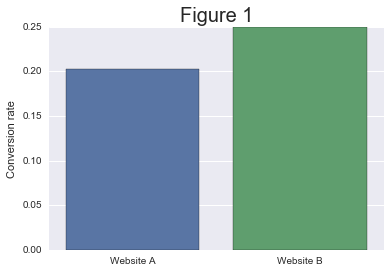

In [144]:
# Website A (Blue):
views_A = 503
regs_A = 102

# Website B (Green):
views_B = 501
regs_B = 125

# Total number of views and registrations on both sites
total = views_A + views_B + regs_A + regs_B

#not_conv: Number of users who have not converted from view to registration.
not_conv_A = views_A - regs_A 
not_conv_B = views_B - regs_B

#Plot of the conversion rate (percent of users that do register after viewing the site)
import seaborn as sns
%matplotlib inline
x = ['Website A', 'Website B']
ax = sns.barplot(x, [regs_A/float(views_A), regs_B/float(views_B)])
ax.set_title('Figure 1', fontsize=20)
sns.axlabel('', 'Conversion rate')

Well that's great: Website B is performing better than Website A, let's move on. Are you sure? There is way more information that we can obtain, such as: **What is the probability that Website B performs better than Website A just by chance?** (If you were to repeat the same experiment how confident are you would that you would observe the same trend?). These questions can be anwsered using classical statistics (Z-test and Chi-square). 

If you think that some events can be described with some 'degrees of belief', and are interested to know about how to quantify them, you should read up to the Bayesian part. We are going to draw distributions, we are going to make it simple. My goal is to share with you the idea that Figure 2 is more beautiful and informative than Figure 1.

# Z-test

In [145]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

views = np.array([views_A, views_B])
regs = np.array([regs_A,regs_B])

z,p = proportions_ztest(regs, views, value=0)
print('z-stat = {} \np-value = {}'.format(z, p/2))

z-stat = -1.76940686107 
p-value = 0.0384130007337


# Chi square

In [146]:
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency([[regs_A, not_conv_A], [regs_B, not_conv_B]], correction=False)
print "p-value =", p/2

p-value = 0.0384130007337


# Bayesian inference, Beta distribution

In [147]:
from numpy.random import beta as beta_dist

A_samples = beta_dist(regs_A, not_conv_A, total)
B_samples = beta_dist(regs_B, not_conv_B, total)

proba = np.mean(B_samples > A_samples)
print('Probability = {}'.format(proba))

np.mean(100.*(B_samples - A_samples)/A_samples > 5)

Probability = 0.968318440292


0.90414297319252646

0.20367491213439318

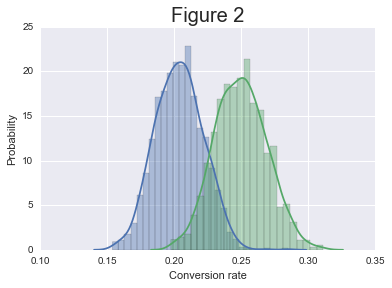

In [148]:
ax = sns.distplot(A_samples)
ax = sns.distplot(B_samples)
ax.set_title('Figure 2', fontsize=20)
sns.axlabel('Conversion rate', 'Probability')

np.mean(A_samples)

References: 

http://www.evanmiller.org/bayesian-ab-testing.html

http://engineering.richrelevance.com/bayesian-ab-tests/

http://dogdogfish.com/ab-testing/bayesian-ab-testing-using-python/

http://www.prenhall.com/behindthebook/0136149901/pdf/Levine_CH12.pdf